In [1]:
!pip install datasets transformers pytorch_metric_learning umap-learn seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from pytorch_metric_learning.losses import NTXentLoss, SupConLoss, CrossBatchMemory
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
from timeit import default_timer as dtimer

In [3]:
# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': label
        }

In [4]:
# Contrastive BERT model with projection head
class BertEmo(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-cased', projection_dim=64, drop_out_rate=0.1):
        super(BertEmo, self).__init__()
        self.encoder = BertModel.from_pretrained(pretrained_model_name)
        # self.projection = nn.Sequential(
        #     nn.Linear(self.encoder.config.hidden_size, projection_dim),
        #     nn.ReLU(),
        #     nn.Dropout(p=drop_out_rate),
        #     nn.Linear(projection_dim, projection_dim)
        # )
        self.projection = nn.Linear(self.encoder.config.hidden_size, projection_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0]  # [CLS] token
        projection = self.projection(cls_embedding)
        return F.normalize(projection, p=2, dim=1), cls_embedding

In [5]:
# Visualization with UMAP
def plot_umap(emotions_list, embeddings, labels, title):
    #emotion_names = [emotions_list[int(label)] for label in labels]
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)
    plt.figure(figsize=(12, 10))
    emo_palette = sns.color_palette("Spectral", len(emotions_list))
    emo_plot = sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=emo_palette, s=10)
    emp_patches = [mpatches.Patch(color=emo_palette.as_hex()[label]) for label in range(len(emotions_list))]
    plt.legend(handles=emp_patches, labels=emotions_list, loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, title="Emotions")
    plt.title(title)
    plt.show()

In [6]:
# Supervised contrastive loss function with vector space preservation
class CombinedLoss(nn.Module):
    def __init__(self, temperature=0.05, lambda_vsp=0.05, cross_batch_memory_size=1024, embedding_size=64):
        super(CombinedLoss, self).__init__()
        self.supConLoss = CrossBatchMemory(loss=SupConLoss(temperature=temperature), memory_size=cross_batch_memory_size, embedding_size=embedding_size)
        self.lambda_vsp = lambda_vsp

    def forward(self, projections, labels, original_embeddings, current_embeddings):
        # Supervised contrastive loss
        loss_scl = self.supConLoss(projections, labels)

        # Vector space preservation loss
        loss_vsp = F.mse_loss(current_embeddings, original_embeddings)

        # Combined loss
        return loss_scl + self.lambda_vsp * loss_vsp

In [7]:
# utility functions for retrieval metrics
def precision_at_1(embeddings, labels, distances):
    correct_at_1 = 0
    num_queries = len(embeddings)

    for i in range(num_queries):
        # Sort by similarity (closest distance) and exclude self-comparison
        closest_idx = np.argsort(distances[i])[1]  # Exclude self at index 0
        if labels[i] == labels[closest_idx]:
            correct_at_1 += 1

    return correct_at_1 / num_queries

def mean_reciprocal_rank(embeddings, labels, distances):
    reciprocal_ranks = []
    num_queries = len(embeddings)

    for i in range(num_queries):
        sorted_indices = np.argsort(distances[i])
        for rank, idx in enumerate(sorted_indices[1:], start=1):  # Exclude self-comparison
            if labels[i] == labels[idx]:
                reciprocal_ranks.append(1 / rank)
                break

    return np.mean(reciprocal_ranks)

def mean_average_precision_at_r(embeddings, labels, distances):
    average_precisions = []
    num_queries = len(embeddings)

    for i in range(num_queries):
        # Get indices sorted by similarity (closest distance), excluding the self-comparison at index 0
        sorted_indices = np.argsort(distances[i])[1:]

        # Determine r based on the number of items with the same label as the query
        same_label_count = np.sum(labels == labels[i])
        relevant_indices = sorted_indices[:same_label_count]

        # Calculate average precision for the top `same_label_count` items
        correct_count = 0
        precision_sum = 0

        for rank, idx in enumerate(relevant_indices, start=1):
            if labels[i] == labels[idx]:
                correct_count += 1
                precision_sum += correct_count / rank

        # Average precision for this query
        if correct_count > 0:
            average_precisions.append(precision_sum / same_label_count)
        else:
            average_precisions.append(0)

    return np.mean(average_precisions)

In [8]:
# Function to evaluate clustering and retrieval metrics using only the encoder after discarding the projection head
def evaluate_metrics(pretrained_embeddings, all_embeddings, all_labels, num_clusters = 28):
    
    # Clustering using KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_embeddings)
    ami = adjusted_mutual_info_score(all_labels, cluster_labels)
    ari = adjusted_rand_score(all_labels, cluster_labels)
    fms = fowlkes_mallows_score(all_labels, cluster_labels)

    # Retrieval metrics
    distances = pairwise_distances(all_embeddings, metric='cosine')
    mrr = mean_reciprocal_rank(all_embeddings, all_labels, distances)
    p_at_1 = precision_at_1(all_embeddings, all_labels, distances)
    map_at_r = mean_average_precision_at_r(all_embeddings, all_labels, distances)
    
    # ∆emb calculation - Mean Cosine Distance between emotion-aware and pre-trained embeddings
    cos_sim = nn.CosineSimilarity(dim=1, eps=1e-8)
    all_embeddings_torch = torch.from_numpy(all_embeddings)
    pretrained_embeddings_torch = torch.from_numpy(pretrained_embeddings)
    all_cos_sim = cos_sim(all_embeddings_torch, pretrained_embeddings_torch)
    delta_emb = torch.mean(1 - all_cos_sim)

    return ami, ari, fms, mrr, p_at_1, map_at_r, delta_emb

In [9]:
# Training loop
def train(bert_original, model, data_loader, criterion, optimizer, num_epochs, device = 'cpu'):
    for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      start_time = dtimer()
      batch_num = 0
      for batch in data_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          # Encode with fixed encoder for VSP
          with torch.no_grad():
              original_embeddings = bert_original(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]

          # Get projections and current embeddings
          projections, current_embeddings = model(input_ids, attention_mask)

          # Compute loss
          loss = criterion(projections, labels, original_embeddings, current_embeddings)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          if batch_num % 100 == 0:
              print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_num + 1}/{len(data_loader)}, Batch Loss: {loss.item()}")
          batch_num += 1

      total_time = round((dtimer() - start_time) / 60, 2)
      print(f"Epoch {epoch + 1}/{num_epochs}, Total loss: {total_loss}, epoch training time: {total_time} minutes")

In [10]:
# Define parameters
pretrained_model_name = 'bert-base-cased'
projection_dim = 64
batch_size = 64
learning_rate = 5e-6
cross_batch_memory_size = 1024
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f'Using device: {device}')

# Load the GoEmotions dataset
ds = load_dataset("google-research-datasets/go_emotions", "simplified")
train_texts = []
train_labels = []

for text, labels in zip(ds['train']['text'], ds['train']['labels']):
    if len(labels) == 1:
        train_texts.append(text)
        train_labels.append(labels[0])

print(f"Number of training samples : {len(train_labels)}")

# Initialize the tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name, clean_up_tokenization_spaces=True)
dataset = EmotionDataset(train_texts, train_labels, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the original bert model
bert_original = BertModel.from_pretrained(pretrained_model_name)
bert_original.to(device)

# Initialize model, criterion, and optimizer
model = BertEmo(pretrained_model_name, projection_dim).to(device)
criterion = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Using device: cuda
Number of training samples : 36308


In [11]:
# Train the model
# train(bert_original, model, data_loader, criterion, optimizer, num_epochs, device)

In [12]:
model_path = "BertEmo3.pth"
optimizer_path = "BertEmoOptimizer3.pth"
# torch.save(model.state_dict(), model_path)
# torch.save(optimizer.state_dict(), optimizer_path)
# print("Model saved successfully !")

In [13]:
model = BertEmo(pretrained_model_name, projection_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
optimizer.load_state_dict(torch.load(optimizer_path, map_location=device, weights_only=True))

In [14]:
print("Model loaded successfully !")

Model loaded successfully !


In [15]:
# Check the test dataset
test_texts = []
test_labels = []

for text, labels in zip(ds['test']['text'], ds['test']['labels']):
    if len(labels) == 1:
        test_texts.append(text)
        test_labels.append(labels[0])

print(f"Number of testing samples : {len(test_labels)}")

# Initialize the tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name, clean_up_tokenization_spaces=True)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)
data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of testing samples : 4590


In [16]:
model = model.to(device)
model.eval()
all_embeddings = []
original_embeddings = []
all_labels = []
with torch.no_grad():
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        # Obtain emotion-aware embeddings directly from the encoder without the projection head
        cls_embeddings = model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        cls_original_embeddings = bert_original(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        all_embeddings.append(cls_embeddings.cpu().numpy())
        original_embeddings.append(cls_original_embeddings.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_embeddings = np.vstack(all_embeddings)
original_embeddings = np.vstack(original_embeddings)
all_labels = np.array(all_labels)

In [17]:
# Evaluate metrics
ami, ari, fms, mrr, p_at_1, map_at_r, delta_emb = evaluate_metrics(original_embeddings, all_embeddings, all_labels)
print(f"AMI: {ami}, ARI: {ari}, FMS: {fms}")
print(f"MRR: {mrr}, P@1: {p_at_1}, MAP@r: {map_at_r}")
print(f"∆emb: {delta_emb}")

AMI: 0.4031146987673145, ARI: 0.2298828495907809, FMS: 0.32416971050796584
MRR: 0.6323960291736185, P@1: 0.5152505446623094, MAP@r: 0.31169933657136206
∆emb: 0.3557324707508087


In [18]:
# Define emotions list
emotions_list = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral']

/home/soumya/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


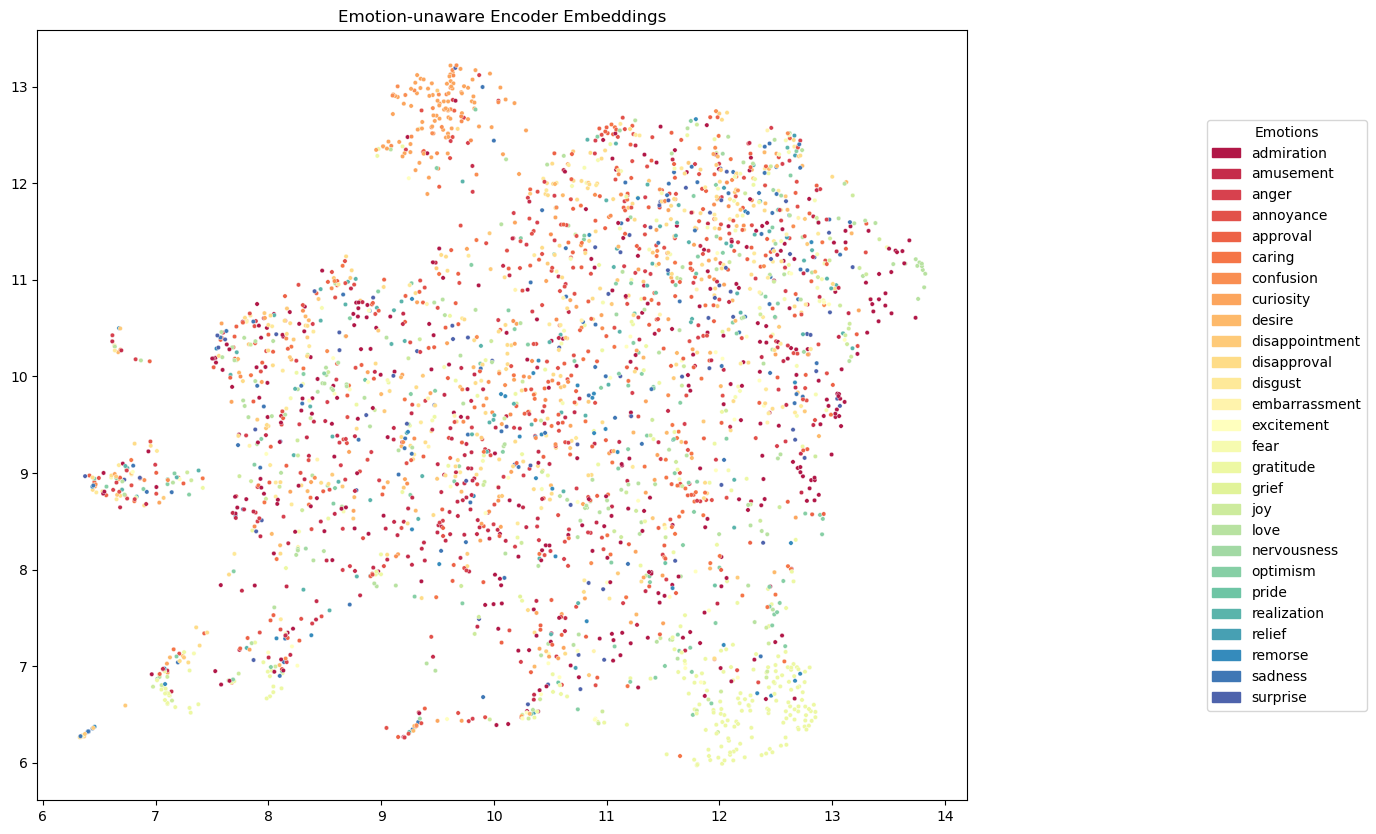

In [19]:
# UMAP with BERT Original
# Plot after removing the neutral emotions
original_embeddings_emo = []
all_labels_emo = []
for embedding, label in zip(original_embeddings, all_labels):
    if label != 27:
        original_embeddings_emo.append(embedding)
        all_labels_emo.append(label)

original_embeddings_emo = np.array(original_embeddings_emo)
all_labels_emo = np.array(all_labels_emo)
plot_umap(emotions_list[:-1], original_embeddings_emo, all_labels_emo, title="Emotion-unaware Encoder Embeddings")

/home/soumya/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


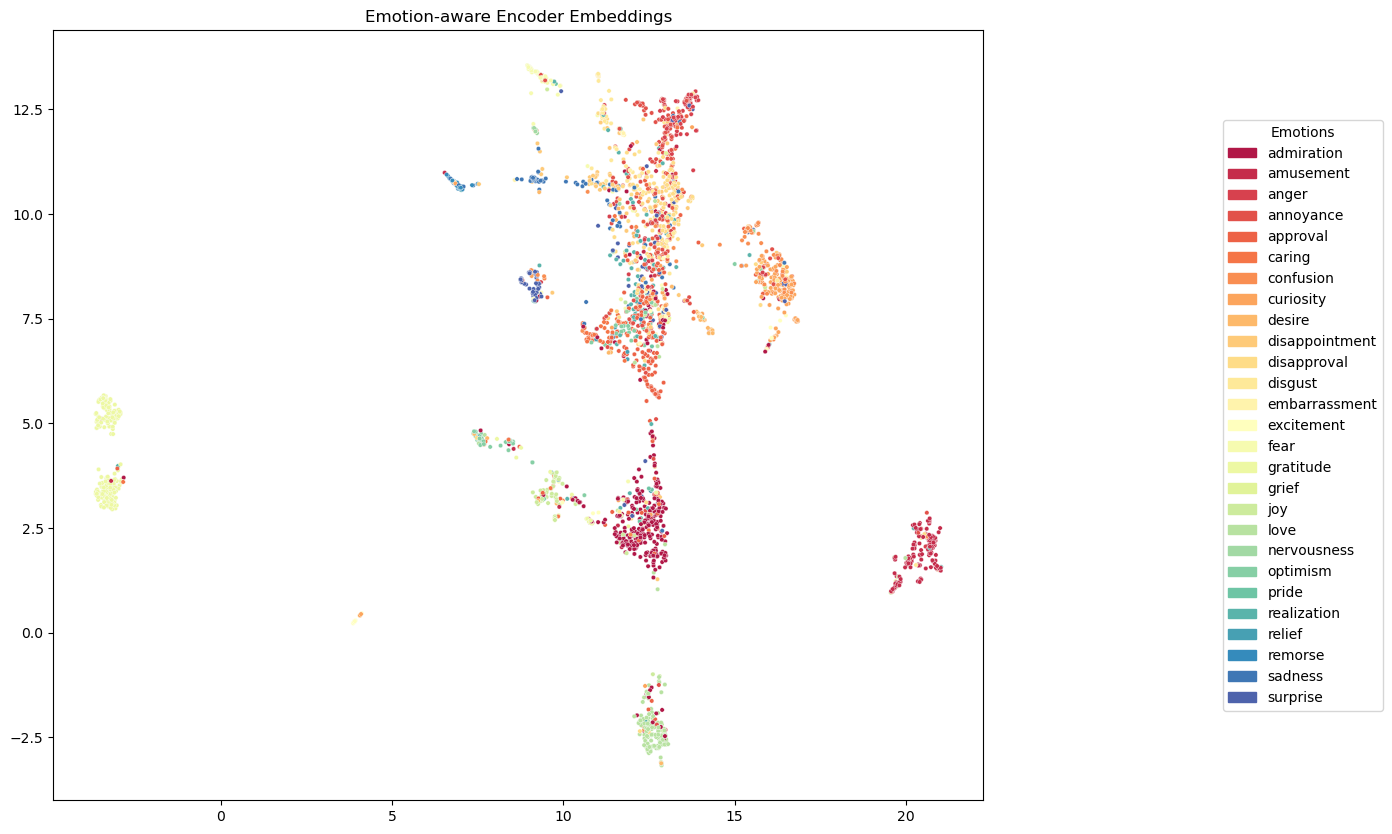

In [20]:
# UMAP with BertEmo
# Plot after removing the neutral emotions
all_embeddings_emo = []
all_labels_emo = []
for embedding, label in zip(all_embeddings, all_labels):
    if label != 27:
        all_embeddings_emo.append(embedding)
        all_labels_emo.append(label)

all_embeddings_emo = np.array(all_embeddings_emo)
all_labels_emo = np.array(all_labels_emo)
plot_umap(emotions_list[:-1], all_embeddings_emo, all_labels_emo, title="Emotion-aware Encoder Embeddings")